### Load data
Downloading each article category in KalimatCorpus-2.0 from sourceforge.net
- Each category is in a folder, with all articles as .txt
- All articles are written words each in a line

In [1]:
import os
import multiprocessing.dummy as mp

In [2]:
kalimat_base = "data\\KalimatCorpus-2.0"
expected_dirs = os.listdir(kalimat_base)

#### Checking for the existence of the directories

In [3]:
def check_kalimat_structure_os():
    missing = [d for d in expected_dirs if not os.path.isdir(os.path.join(kalimat_base, d))]
    
    if missing:
        print(f"❌ Missing folders: {missing}")
    else:
        count = 0
        for d in expected_dirs:
            folder_path = os.path.join(kalimat_base, d)
            count += len([f for f in os.listdir(folder_path)])
        print(f"✅ Kalimat Corpus is ready with {count} .txt files")

check_kalimat_structure_os()

✅ Kalimat Corpus is ready with 18256 .txt files


#### `load_kalimat_articles`
We went through each folder `category` pass it to `load_kalimat_articles`. 
This function will read all the articles, append them to articles list with the following information:
- `category`: the name of the folder
- `filename`: the name of the file
- `text`: the content of the article
- `text_length`: the length of the article in characters
- `word_count`: the number of words in the article

In [4]:
def load_kalimat_articles(category):
    category_path = os.path.join(kalimat_base, category)
    if not os.path.isdir(category_path):
        print(f"❌ Category '{category}' does not exist in the Kalimat Corpus.")
        return []

    articles = []
    for filename in os.listdir(category_path):
        if filename.endswith(".txt"):
            file_path = os.path.join(category_path, filename)
            with open(file_path, 'r', encoding='utf-8') as f:
                words = [line.strip() for line in f if line.strip()]
                text = " ".join(words)
                articles.append({
                    "category": category.replace("articles", "").upper(),
                    "filename": filename,
                    "text": text,
                    "text_length": len(text),
                    "word_count": len(words)
                })

    print(f"✅ Loaded {len(articles)} articles from category '{category}'")
    return articles

Parellalize the loading of articles using `multiprocessing` to speed up the process.

Then in `dataset` we flat the list of articles to one array instead of a list of lists.

In [5]:
def load_all_articles_parallel():
    with mp.Pool(processes=min(len(expected_dirs), int(os.cpu_count() / 2))) as pool:
        results = pool.map(load_kalimat_articles, expected_dirs)
    
    dataset = [article for category_articles in results for article in category_articles]
    return dataset

`if __name__ == "__main__"` is Important to solve an issue in Windows OS with `multiprocessing` module.

In [6]:
if __name__ == "__main__":
    dataset = load_all_articles_parallel()
    print(f"✅ Dataset loaded with {len(dataset)} articles.")

✅ Loaded 1689 articles from category 'articlesInternational'
✅ Loaded 2495 articles from category 'articlesCulture'
✅ Loaded 4095 articles from category 'articlesSports'
✅ Loaded 3237 articles from category 'articlesLocal'
✅ Loaded 3475 articles from category 'articlesReligion'
✅ Loaded 3265 articles from category 'articlesEconomy'
✅ Dataset loaded with 18256 articles.


### Preprocessing
Say Hello to pandas!

We will start by constructing a DataFrame from the dataset list of dictionaries.

In [7]:
import pandas as pd
df = pd.DataFrame(dataset)
df.head(), df['category'].value_counts()

(  category             filename  \
 0  CULTURE     culturecapr1.txt   
 1  CULTURE  culturecapr1005.txt   
 2  CULTURE  culturecapr1006.txt   
 3  CULTURE  culturecapr1007.txt   
 4  CULTURE  culturecapr1008.txt   
 
                                                 text  text_length  word_count  
 0  كتب سالم الرحبي : تنطلق اليوم الدورة البرامجية...        15739        2732  
 1  كتب - فيصل العلوي : شاركت السلطنة صباح امس دول...         5057         835  
 2  اربعة عروض على مسرح الشباب وعرض في الرستاق ثم ...         3892         691  
 3  حاوره خالد عبداللطيف : حين يناقش الموضوع الثقا...        11757        1972  
 4  افتتح صباح أمس بقاعة الموسيقي في جامعة السلطان...         1946         329  ,
 category
 SPORTS           4095
 RELIGION         3475
 ECONOMY          3265
 LOCAL            3237
 CULTURE          2495
 INTERNATIONAL    1689
 Name: count, dtype: int64)

#### Setup necessary libraries
- `nltk` for text processing
- `nltk.corpus.stopwords` for stop words
- `regex`

Then downloading the stop words using `nltk.download()` function.
- `stopwords` is a list of common words that are not useful for text analysis (e.g. "في", "من", "إلى", "على", "و")


In [8]:
import nltk
from nltk.corpus import stopwords
import regex as re

nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sauda\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Adding additional stopwords based on our analysis of the corpus

In [9]:
arabic_stopwords = set(stopwords.words('arabic'))
stemmer = nltk.stem.ISRIStemmer() # Worsen the results
for word in ['في', 'ان', 'ان', 'الى', 'او', 'فى']: arabic_stopwords.add(word)
print(f"Stop words count: {len(arabic_stopwords)}")

Stop words count: 705


#### `preprocess_text`
We applied `preprocess_text` to clean and normalize the Arabic text before modeling.  
This function performs the following steps:
- **Remove** punctuation, digits (Arabic and English), and English letters.
- **Normalize** Arabic letters by unifying variants (e.g., "أ", "إ", "آ" → "ا").
- **Remove** Arabic diacritics and extra whitespace.
- **Tokenize** the text and **remove** Arabic stopwords.
- Finally, **join** the tokens back into a cleaned string.

In [10]:
def preprocess_text(text):

    text = re.sub(r'\p{P}+|\$', '', text)  # remove all punctuation (English + Arabic)
    text = re.sub(r'[0-9٠-٩]', '', text)  # remove Arabic and English digits
    text = re.sub(r'[a-zA-Z]', '', text)  # remove English letters
    text = re.sub(r'[اآإأ]', 'ا', text)  # replace Arabic letter with hamza with 'ا'
    text = re.sub(r'[\u064B-\u0652]', '', text)  # remove Arabic diacritics
    text = re.sub(r'\s+', ' ', text).strip()  # clean extra spaces

    tokens = text.split()
    tokens = [stemmer.stem(word) for word in tokens if word not in arabic_stopwords]


    return ' '.join(tokens)

preprocess_text("!مرحباً... هذا نَصٌّ تَجْرِيبِيٌ يحتوي على 123 أرقام ٤٥٦، في علامات ترقيم @#$%، كلمات إنجليزية like This.")

'رحب نص جرب حوي رقم علم رقم كلم انجليزية'

Now we can apply the `preprocess_text` function to the DataFrame creating a new column `processed_text`

In [11]:
df['processed_text'] = df['text'].apply(preprocess_text)

### Visualization

In [12]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from collections import Counter
import arabic_reshaper
from bidi.algorithm import get_display
%matplotlib inline

fm.fontManager.addfont('arial-unicode-ms.ttf')
arabic_font = fm.FontProperties(fname='arial-unicode-ms.ttf')

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = arabic_font.get_name()

               Unique  Duplicate
category                        
CULTURE          2435         60
ECONOMY          3202         63
INTERNATIONAL    1624         65
LOCAL            3043        194
RELIGION           57       3418
SPORTS           4035         60


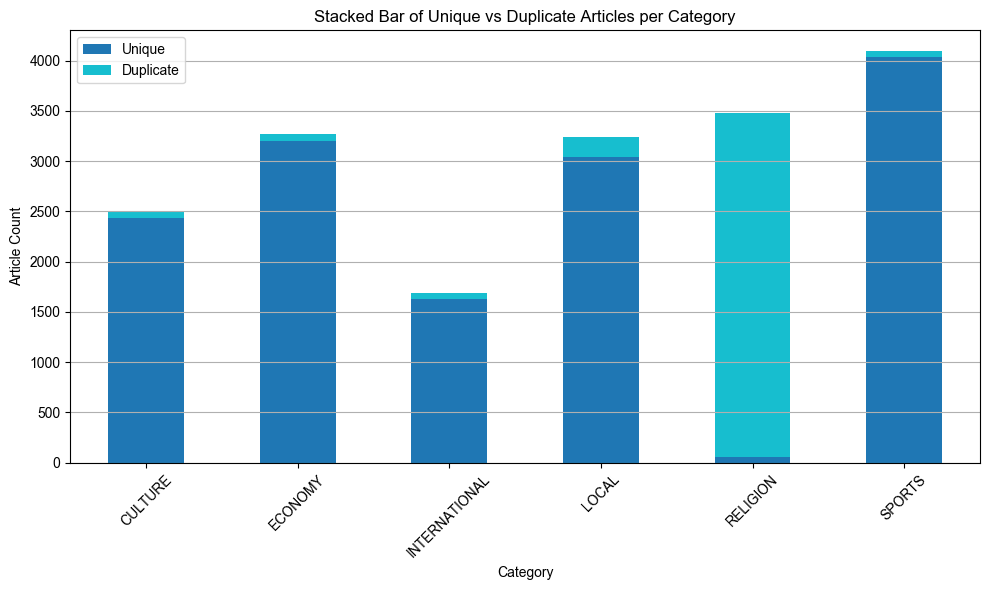

In [13]:
df['is_duplicate'] = df.duplicated(subset='processed_text', keep=False)

# Group and make sure both True/False appear
counts = df.groupby(['category', 'is_duplicate']).size().unstack().reindex(columns=[False, True], fill_value=0)
counts.columns = ['Unique', 'Duplicate']
print(counts)
# Plot
counts.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='tab10')
plt.title("Stacked Bar of Unique vs Duplicate Articles per Category")
plt.xlabel("Category")
plt.ylabel("Article Count")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


#### 1- Stacked Bar: Unique vs Duplicate Articles per Category
While most categories have a healthy distribution of unique articles, the `RELIGION` category has a significant number of duplicate articles. This could bias classification models if not properly handled.

In [14]:
df = df.drop_duplicates(subset=['processed_text'])

#### 2- Vocabulary Size
After preprocessing, the corpus contains ~235k unique words. Such size will impact the dimensionality of the feature extraction methods like TF-IDF.

In [15]:
vocab = set()
df['processed_text'].str.split().apply(vocab.update)
len(vocab)

33336

#### 3- Top 20 Most Common Words (Bar Chart)
The most frequent words in the corpus. we can see "السلطنة" which make sense as the corpus if of Omani articles.

In [16]:
word_counts = Counter()
_ = df['processed_text'].str.split().apply(word_counts.update)


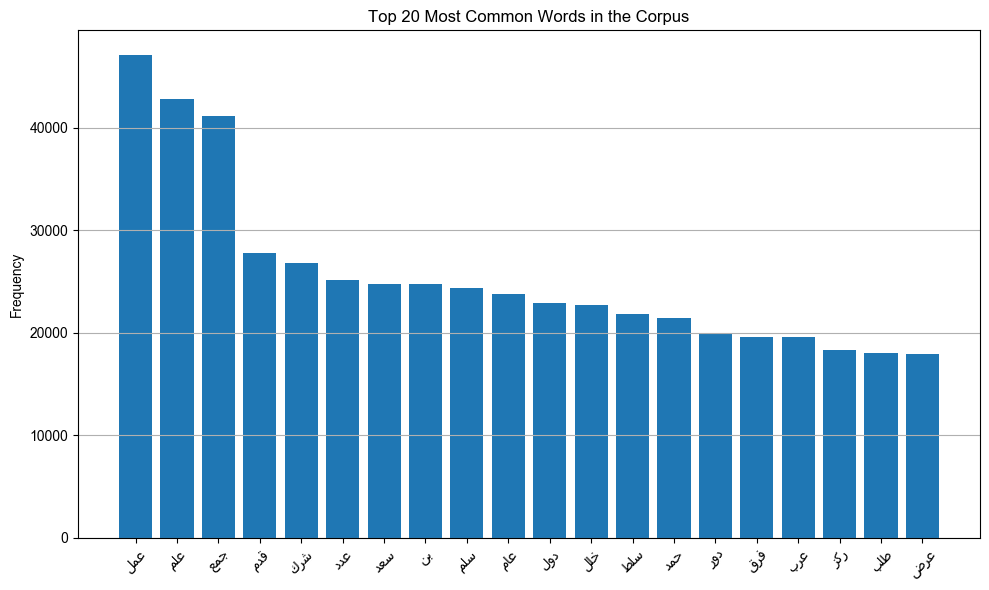

In [17]:
common_words = word_counts.most_common(20)

words, counts = zip(*common_words)
display_words = list(map(get_display, map(arabic_reshaper.reshape, words)))
plt.figure(figsize=(10, 6))
plt.bar(display_words, counts)
plt.title("Top 20 Most Common Words in the Corpus")
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

#### 4- Article Word Counts per Category (Box Plot)
The median article length is different across categories. `RELIGION` articles tend to be longer on average, while `SPORTS` articles are shorter.

<Figure size 1200x600 with 0 Axes>

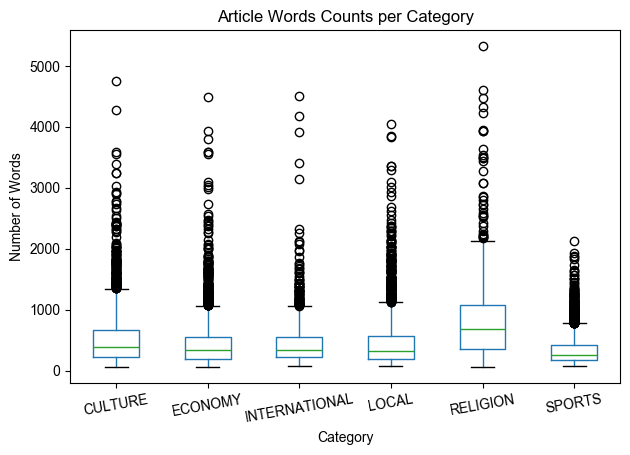

In [18]:
plt.figure(figsize=(12,6))
df.boxplot(column='word_count', by='category', grid=False, rot=10)
plt.title('Article Words Counts per Category') 
plt.suptitle('')  # Remove the automatic "Boxplot grouped by" title
plt.xlabel('Category')
plt.ylabel('Number of Words')
plt.tight_layout()
plt.show()

#### 5- Top 20 Bigrams (Horizontal Bar Chart)
Common bigrams such as "السلطان قابوس","بن سعيد", and "محمد بن" appear frequently in the corpus, Capturing common word expressions in Omani journalism.

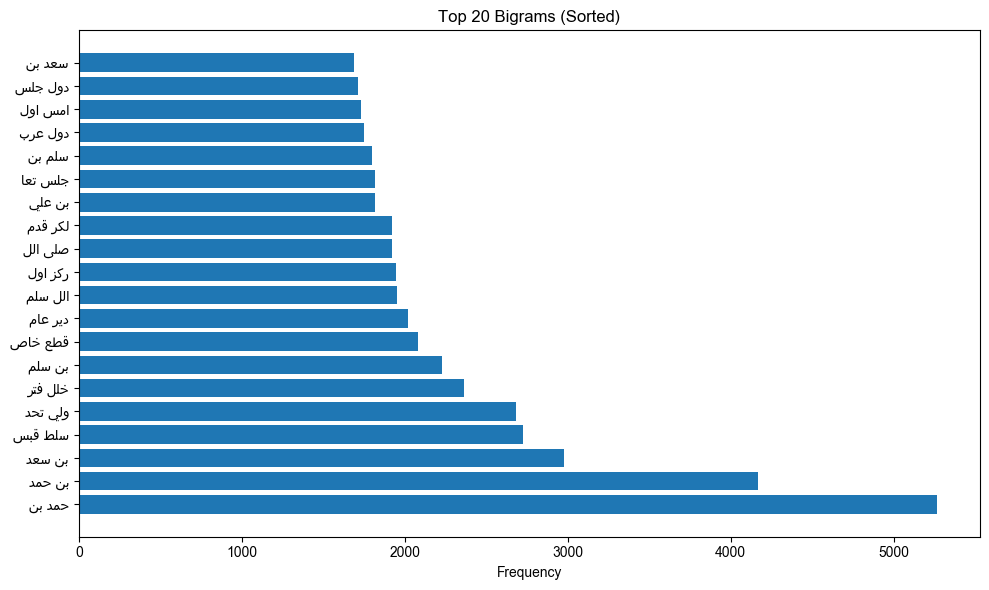

In [19]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(ngram_range=(2,2), max_features=20)
X = vectorizer.fit_transform(df['processed_text'])
bigrams = vectorizer.get_feature_names_out()

counts = X.sum(axis=0).A1
display_words = list(map(get_display, map(arabic_reshaper.reshape, bigrams)))

bigrams_counts = list(zip(display_words, counts))
bigrams_counts.sort(key=lambda x: x[1], reverse=True)
sorted_display_words, sorted_counts = zip(*bigrams_counts)
# Plot
plt.figure(figsize=(10,6))
plt.barh(sorted_display_words, sorted_counts)
plt.title('Top 20 Bigrams (Sorted)')
plt.xlabel('Frequency')
plt.tight_layout()
plt.show()


### Task 1: Text Classification

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df['processed_text'])

We Tried every combination of Traditional methods `BoW` , `TfIdf` and `SVM` , `Naive Bayes` , `Random Forest` for classification.

In general `TfIdf` was better than `BoW` as for the algorithms of learning the best accuracy was from `SVM` with `TfIdf` . `Naive bayes` is the fastest with under 1 sec and very good accuracy. `Random Forest` has good accuracy but it took longer time .

In [21]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import numpy as np

X = tfidf_matrix
y = df['category']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

svm_classifier = LinearSVC(random_state=42, C=1.0)
nb_classifier = MultinomialNB(alpha=0.01)
svm_classifier.fit(X_train, y_train), nb_classifier.fit(X_train, y_train)

(LinearSVC(random_state=42), MultinomialNB(alpha=0.01))

#### Results Summary
- `SVM` + `TfIdf` : Gave us the best f1-score average accuracy of 92%
- Mean Cross Validation Score: 90.60%
- `Naive Bayes` + `TfIdf` : Gave us the second best f1-score average accuracy of 88%
- Mean Cross Validation Score: 87.73%

In [22]:
def show_confusion_matrix(y_true, y_pred, labels=None, normalize=False, figsize=(6, 4), title="Confusion Matrix"):
    if labels is None:
        labels = sorted(list(set(y_true) | set(y_pred)))

    cm = confusion_matrix(y_true, y_pred, labels=labels)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
        fmt = ".2f"
    else:
        fmt = "d"

    plt.figure(figsize=figsize)
    sns.heatmap(cm, annot=True, fmt=fmt, cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(title)
    plt.xticks(rotation=45, ha='right')  # Tilt x-axis labels
    plt.tight_layout()
    plt.show()


SVM Classifier Evaluation

Cross-Validation Scores: [0.90743802 0.89917355 0.92231405 0.90909091 0.88410596]
Mean Cross-Validation Score: 0.9044

 Model Evaluation
Accuracy: 0.923941798941799

Classification Report:
               precision    recall  f1-score   support

      CULTURE       0.92      0.91      0.91       493
      ECONOMY       0.90      0.90      0.90       647
INTERNATIONAL       0.95      0.94      0.95       331
        LOCAL       0.86      0.87      0.86       628
     RELIGION       0.90      0.89      0.90       112
       SPORTS       0.99      0.99      0.99       813

     accuracy                           0.92      3024
    macro avg       0.92      0.92      0.92      3024
 weighted avg       0.92      0.92      0.92      3024


Confusion Matrix:


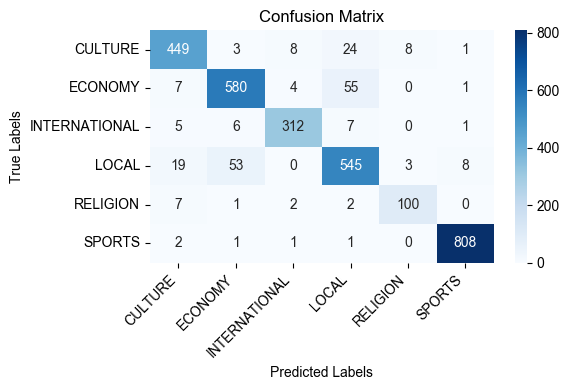



Naive Bayes Classifier Evaluation

Cross-Validation Scores: [0.89752066 0.85785124 0.89752066 0.86942149 0.86423841]
Mean Cross-Validation Score: 0.8773

 Model Evaluation
Accuracy: 0.8802910052910053

Classification Report:
               precision    recall  f1-score   support

      CULTURE       0.87      0.85      0.86       493
      ECONOMY       0.87      0.85      0.86       647
INTERNATIONAL       0.94      0.95      0.94       331
        LOCAL       0.75      0.84      0.80       628
     RELIGION       0.82      0.79      0.80       112
       SPORTS       0.99      0.94      0.96       813

     accuracy                           0.88      3024
    macro avg       0.87      0.87      0.87      3024
 weighted avg       0.88      0.88      0.88      3024


Confusion Matrix:


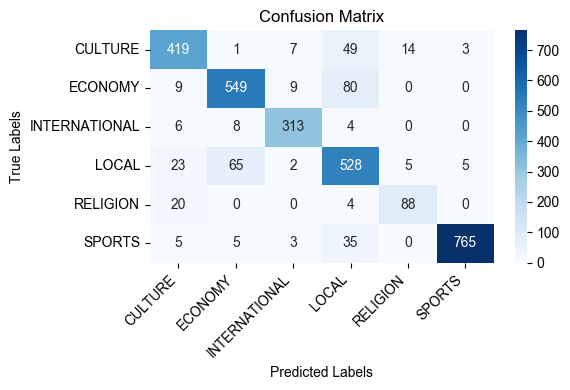

In [23]:
def model_evaluation(classifier, X, y):
    y_pred = classifier.predict(X)
    cv_scores = cross_val_score(classifier, X, y, cv=5, scoring='accuracy')

    print(f'\nCross-Validation Scores: {cv_scores}')
    print(f'Mean Cross-Validation Score: {np.mean(cv_scores):.4f}')

    print("\n Model Evaluation")
    accuracy = accuracy_score(y, y_pred)
    print(f"Accuracy: {accuracy}")

    print("\nClassification Report:")
    class_report = classification_report(y, y_pred, target_names=sorted(y.unique()))
    print(class_report)

    print("\nConfusion Matrix:")
    cm = show_confusion_matrix(y_test, y_pred, labels=sorted(y_test.unique()))

print("SVM Classifier Evaluation")
model_evaluation(svm_classifier, X_test, y_test)
print("\n" + "="*50 + "\n")
print("Naive Bayes Classifier Evaluation")
model_evaluation(nb_classifier, X_test, y_test)

#### Prediction function that uses the SVM + TfIdf model
- The funciton takes a string as input
- Preprocess the text
- Transform the text using the `tfidf_vectorizer`
- Predict the category using the `svm_model`
- Return the predicted category

In [24]:
def predict_category(text):
    tokenized_text = preprocess_text(text)
    X_new = tfidf_vectorizer.transform([tokenized_text])
    return svm_classifier.predict(X_new)[0]

In [25]:
print("CULTURE →", predict_category("أطلقت وزارة الثقافة برنامجًا وطنيًا يهدف إلى إحياء التراث الشعبي من خلال دعم الفنون التقليدية والمهرجانات المحلية التي تسلط الضوء على الهوية السعودية."))
print("ECONOMY →", predict_category("شهدت الأسواق المالية ارتفاعًا ملحوظًا في قيمة الأسهم السعودية بعد إعلان الحكومة عن خطة تنموية جديدة تركز على التنوع الاقتصادي وتقليل الاعتماد على النفط."))
print("INTERNATIONAL →", predict_category("عقدت القمة الخليجية الأوروبية اجتماعها السنوي في بروكسل لمناقشة التحديات العالمية مثل الأمن الغذائي والتغير المناخي وتعزيز التعاون بين الشرق والغرب."))
print("LOCAL →", predict_category("بدأت أمانة المدينة بتنفيذ مشروع توسعة الطرق الداخلية بهدف تخفيف الازدحام المروري، كما تم الإعلان عن إنشاء ممرات مشاة ومواقف ذكية."))
print("RELIGION →", predict_category("حثّ إمام المسجد خلال خطبة الجمعة على التمسك بالقيم الإسلامية ونشر التسامح بين أفراد المجتمع، مشيرًا إلى أهمية الصدق والأمانة في التعاملات اليومية."))
print("SPORTS →", predict_category("تمكن المنتخب الوطني من الفوز على نظيره الإيراني في مباراة مثيرة انتهت بنتيجة ٣-٢، ليضمن التأهل إلى نهائي كأس آسيا وسط فرحة جماهيرية عارمة."))

CULTURE → CULTURE
ECONOMY → ECONOMY
INTERNATIONAL → INTERNATIONAL
LOCAL → LOCAL
RELIGION → LOCAL
SPORTS → SPORTS


### 🔍 Observations On The Predictions
* The model correctly predicted **5 out of 6** categories.
* The **RELIGION** article was misclassified as **LOCAL**, likely due to **data imbalance** or **semantic overlap** in community-related language.
* Overall, the model demonstrates **strong accuracy**, with minor limitations in underrepresented categories.

Let me know if you want this phrased formally for a report or presentation.


### Task 2: Text Generation
We needed to use different preprocessing step to get rid of stemming and other steps that will ruin the generation of text.

In [26]:
def preprocess_arabic_text(text):
    # Remove non-Arabic characters and normalize whitespace
    text = re.sub(r'[^\u0600-\u06FF\s]', ' ', text) # keep only Arabic characters
    text = re.sub(r'[\u064B-\u0652]', '', text)  # remove Arabic diacritics
    text = re.sub(r'\s+', ' ', text).strip() # normalize whitespace
    text = re.sub(r'[اآإأ]', 'ا', text)  # replace Arabic letter with hamza with 'ا'

    return text
preprocess_arabic_text("!مرحباً... هذا نَصٌّ تَجْرِيبِيٌ يحتوي على 123 أرقام ٤٥٦، في علامات ترقيم @#$%، كلمات إنجليزية like This.")

'مرحبا هذا نص تجريبي يحتوي على ارقام ٤٥٦، في علامات ترقيم ، كلمات انجليزية'

In [27]:
from collections import defaultdict

# Function to build n-gram model
def build_ngram_model(texts, n):
    model = defaultdict(list)
    all_words = []
    
    for text in texts:
        # Preprocess the text
        text = preprocess_arabic_text(text)
        # Split into words
        words = text.split()
        all_words.extend(words)
        
        # Build n-grams
        for i in range(len(words) - n + 1):
            # Use tuple of n-1 words as key
            prefix = tuple(words[i:i+n-1])
            # Use the nth word as value
            suffix = words[i+n-1]
            model[prefix].append(suffix)
    
    return model, list(set(all_words))

In [28]:
import random
# Function to generate text with a random start word
def generate_arabic_text(model, all_words, length=100, n=5):
    # Choose a random start word
    start_word = random.choice(all_words)
    
    # Find a valid prefix that contains the start word
    valid_prefixes = [prefix for prefix in model.keys() if start_word in prefix]
    
    # If no valid prefix contains the start word, just use any prefix
    if valid_prefixes:
        current = random.choice(valid_prefixes)
    else:
    # Fall back to any random prefix
        current = random.choice(list(model.keys()))
        start_word = current[0] if len(current) > 0 else start_word  # Update start word to match what we're using

    result = list(current)
    
    # Generate text
    for _ in range(length):
        if current in model:
            # Choose a random next word based on the current n-1 words
            next_word = random.choice(model[current])
            result.append(next_word)
            # Update current context (sliding window)
            current = tuple(result[-(n-1):])
        else:
            # if we reach a dead end, choose a new random prefix
            current = random.choice(list(model.keys()))
            result.extend(current)
    
    return start_word, ' '.join(result)

In [29]:
import time

def build_eval_ngram_model(n, texts):
    model, all_words = build_ngram_model(texts, n)
    print(f"\n✅ N-gram model built with n={n} ({len(model)} prefixes)\n")

    for i in range(3):
        start_word, generated_text = generate_arabic_text(model, all_words, length=30, n=n)
        print(f"🔹 Sample {i+1} (start: '{start_word}'):")
        for word in generated_text.split(): 
            print(word, end=' ', flush=True)
            time.sleep(0.05)
        print('')  # new line after each sample


#### Testing the model from n=1 to n=5

In [34]:
for i in range(5):
    build_eval_ngram_model(i+1, df['text'])


✅ N-gram model built with n=1 (1 prefixes)

🔹 Sample 1 (start: 'تختتم'):
لانها ويعد دهستها دورة التقدم فى عالما على الصحة لدينا العمل الملقاة كالصاروخ بين شيئا 
🔹 Sample 2 (start: 'قصة'):
يوم كل صافي الفريق الفحوصات كروي الدول الكويت من في عزة العربية ومعاني قائما ليلى 
🔹 Sample 3 (start: 'ستالوني'):
انفجار زايد لكرة نشر ويوزيف تحرير الحكومية الفني تعرضت المعلومات انبثقت بهذا المستويات يطلقون للبنات 

✅ N-gram model built with n=2 (234537 prefixes)

🔹 Sample 1 (start: 'والزير'):
والزير سالم بن فيصل العلوي نائب العريف الماس وتملك السنغال ونيجيريا عام لا تستطيع اخفاءها وحين يتحول الى اخر الاصل والله على القوانين وعقد فصلا بتنوف فى قطاع الاتصالات والمشغلين الجدد 
🔹 Sample 2 (start: 'السياسات'):
السياسات وتقييم السندات الجديدة تقول انت متفائل واظن ان فقد كانت كبيرة من الطين بلة ان التواضع فلو فكرنا البشري باعتباره يقدم العازفون الصينيون منافسيهم اورفعهم وطرحهم للجديد واستغلاله و دورة 
🔹 Sample 3 (start: 'يعزب'):
يعزب عنه ابو بكر رضي الله عليه في الحملة الانتخابية فى المعروض منذ بداية فقط 

# Phase 2: Modren Approaches
## Task 1: Deep Learning for Text Classification (BiLSTM Model)

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import numpy as np

1- **Tokenization**

- For the BiLSTM model

In [77]:
tokenized_text = [text.split() for text in df['processed_text']]

from collections import Counter

# Count word frequencies
word_counts = Counter(word for article in tokenized_text for word in article)

# Vocabulary
vocab = {word: idx + 2 for idx, (word, count) in enumerate(word_counts.items())}
vocab['<PAD>'] = 0  # Padding token
vocab['<UNK>'] = 1  # Unknown token

# Reverse vocabulary for decoding
reverse_vocab = {idx: word for word, idx in vocab.items()}

# Stats
print(f"Most common words: {word_counts.most_common(10)}")
print(f"Vocabulary size: {len(vocab)}")

Most common words: [('عمل', 47160), ('علم', 42782), ('جمع', 41139), ('قدم', 27757), ('شرك', 26768), ('عدد', 25173), ('سعد', 24793), ('بن', 24731), ('سلم', 24373), ('عام', 23770)]
Vocabulary size: 33338


- For the Tranformer model

In [78]:
from transformers import AutoTokenizer

model_name = "aubmindlab/bert-base-arabertv02"
tokenizer = AutoTokenizer.from_pretrained(model_name)

1.1 **Tokenizer Encoder and Decoder**

- For the BiLSTM model

In [79]:
def encode_text(article, vocab, max_len):
    tokens = [vocab.get(word, vocab['<UNK>']) for word in article]
    chunks = []

    # Split the tokens into chunks of max_len
    for i in range(0, len(tokens), max_len):
        chunk = tokens[i:i + max_len]
        if len(chunk) < max_len:
            chunk += [vocab['<PAD>']] * (max_len - len(chunk))
        chunks.append(chunk)
        # break # Act as the normal encode function, not chunking

    return chunks

def decode_text(encoded_article, reverse_vocab):
    return ' '.join(reverse_vocab.get(idx, '<UNK>') for idx in encoded_article if idx not in (0, 1))  # Skip PAD and UNK tokens

# Test encoding and decoding
sample_article = tokenized_text[0]
print(f"Sample article encoded and decoded safely: {' '.join([decode_text(chunk, reverse_vocab) for chunk in encode_text(sample_article, vocab, 100)]) == ' '.join(sample_article)}")

Sample article encoded and decoded safely: True


- For the Tranformer model

In [93]:
def encode_text_transformer(text, max_len=128):
    assert max_len < 512, "Max length for BERT should be less than 512 tokens."
    
    tokens = tokenizer.encode(text, add_special_tokens=False)

    chunks = []
    for i in range(0, len(tokens), max_len - 2):
        chunk = tokens[i:i + (max_len - 2)]

        chunk = [2] + chunk + [3]  # Add [CLS] and [SEP] tokens

        padding_length = max_len - len(chunk)
        chunk += [0] * padding_length  # Pad with zeros
        chunks.append(chunk)
    
    return chunks

In [94]:
print(tokenizer.encode("السلام عليكم السلام عليكم السلام عليكم السلام عليكم السلام عليكم السلام عليكم السلام عليكم السلام عليكم السلام عليكم", max_length=24, truncation=True, padding='max_length'))
print(encode_text_transformer("السلام عليكم السلام عليكم السلام عليكم السلام عليكم السلام عليكم السلام عليكم السلام عليكم السلام عليكم السلام عليكم", max_len=12))
# There will be less padding in the encode_text_transformer because chunking adds CLS and SEP

[2, 1624, 10064, 1624, 10064, 1624, 10064, 1624, 10064, 1624, 10064, 1624, 10064, 1624, 10064, 1624, 10064, 1624, 10064, 3, 0, 0, 0, 0]
[[2, 1624, 10064, 1624, 10064, 1624, 10064, 1624, 10064, 1624, 10064, 3], [2, 1624, 10064, 1624, 10064, 1624, 10064, 1624, 10064, 3, 0, 0]]


1.2 **Label Encoding**

In [95]:
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(df['category'])

# Label mapping
label_mapping = {idx: label for idx, label in enumerate(label_encoder.classes_)}
label2id = {label: idx for idx, label in enumerate(label_encoder.classes_)}
decode_labels = lambda idx: label_encoder.inverse_transform(idx)
print(f"Label mapping: {label_mapping}")

Label mapping: {0: 'CULTURE', 1: 'ECONOMY', 2: 'INTERNATIONAL', 3: 'LOCAL', 4: 'RELIGION', 5: 'SPORTS'}


2- **Dataset Preparation**

2.1- **Splitting the Dataset**

In [96]:
class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = torch.tensor(texts, dtype=torch.long)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

3- **Model Architecture**

3.1- **LSTM Model**: Bi-directional LSTM

In [97]:
class BiLSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, num_classes, pad_idx):
        super(BiLSTMClassifier, self).__init__()
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        
        # BiLSTM layer
        self.lstm1 = nn.LSTM(embedding_dim, hidden_dim, num_layers=min(1, num_layers//2), dropout=0.5, bidirectional=True, batch_first=True)

        # fc layer
        self.fc1 = nn.Linear(hidden_dim*2, hidden_dim)

        # Second BiLSTM layer
        self.lstm2 = nn.LSTM(hidden_dim, hidden_dim, num_layers=max(1, num_layers//2), dropout=0.5, bidirectional=True, batch_first=True)

        # Fully connected layer
        self.fc2 = nn.Linear(hidden_dim * 2, num_classes)
    
    def forward(self, x):
        x = self.embedding(x)  # (batch_size, seq_len, embedding_dim)

        lstm1_out, _ = self.lstm1(x)  # (batch_size, seq_len, hidden_dim * 2)
        fc1_out = self.fc1(lstm1_out) # (batch_size, seq_len, hidden_dim)

        lstm2_out, (hidden, _) = self.lstm2(fc1_out)  # (batch_size, seq_len, hidden_dim * 2)

        # Use the final forward and backward hidden states
        out = torch.cat((hidden[0], hidden[1]), dim=1)  # (batch_size, hidden_dim * 2)

        return self.fc2(out)  # (batch_size, num_classes)

3.2- **Transformer Based Model**: AraBERT Model

In [98]:
from transformers import AutoModelForSequenceClassification

# The model can be used like this:
# model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(label_mapping), id2label=label_mapping, label2id=label2id)

4- **Training the Model**

- For the BiLSTM model

In [99]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

eval_interval = 100  # Evaluate every 100 batches
eval_iters = 10 # Number of iterations for evaluation

max_len = 500  # Maximum length of sequences
batch_size = 256 # Batch size for training
lr = 0.004

embedding_dim = 128  # Dimension of word embeddings
num_layers = 8  # Number of LSTM layers
hidden_dim = 128  # Hidden dimension for LSTM

4.1- **Data Loaders**

- For the BiLSTM model

In [101]:
chunked_texts_BiLSTM = []
chunked_labels_BiLSTM = []


for article, label in zip(tokenized_text, encoded_labels):
    chunksBiLSTM = encode_text(article, vocab, max_len)

    chunked_texts_BiLSTM.extend(chunksBiLSTM)
    chunked_labels_BiLSTM.extend([label] * len(chunksBiLSTM))

X_train, X_devtest, y_train, y_devtest = train_test_split(
    chunked_texts_BiLSTM, chunked_labels_BiLSTM, test_size=0.2, stratify=chunked_labels_BiLSTM, random_state=42
)
X_dev, X_test, y_dev, y_test = train_test_split(
    X_devtest, y_devtest, test_size=0.5, stratify=y_devtest, random_state=42
)

train_dataset = TextDataset(X_train, y_train)
dev_dataset = TextDataset(X_dev, y_dev)
test_dataset = TextDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# stats
print(f"BiLSTM Train dataset size: {len(train_dataset)}")
print(f"BiLSTM Dev dataset size: {len(dev_dataset)}")
print(f"BiLSTM Test dataset size: {len(test_dataset)}")

BiLSTM Train dataset size: 14897
BiLSTM Dev dataset size: 1862
BiLSTM Test dataset size: 1863


- For the Tranformer model

In [103]:
chunked_texts_Transformer = []
chunked_labels_Transformer = []


for article, label in zip(tokenized_text, encoded_labels):
    chucksTransformer = encode_text_transformer(' '.join(article), max_len=max_len)

    chunked_texts_Transformer.extend(chucksTransformer)
    chunked_labels_Transformer.extend([label] * len(chucksTransformer))

X_train, X_devtest, y_train, y_devtest = train_test_split(
    chunked_texts_Transformer, chunked_labels_Transformer, test_size=0.2, stratify=chunked_labels_Transformer, random_state=42
)
X_dev, X_test, y_dev, y_test = train_test_split(
    X_devtest, y_devtest, test_size=0.5, stratify=y_devtest, random_state=42
)

train_dataset = TextDataset(X_train, y_train)
dev_dataset = TextDataset(X_dev, y_dev)
test_dataset = TextDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# stats
print(f"Transformer Train dataset size: {len(train_dataset)}")
print(f"Transformer Dev dataset size: {len(dev_dataset)}")
print(f"Transformer Test dataset size: {len(test_dataset)}")

Transformer Train dataset size: 16314
Transformer Dev dataset size: 2039
Transformer Test dataset size: 2040


4.1- **Evaluation Function**: To evaluate the model on the test set

In [50]:
def evaluate_model(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for x, y in test_loader: # x: (batch_size, seq_len), y: (batch_size,)
            x = x.to(device)
            outputs = model(x)  # outputs: (batch_size, num_classes)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(y.numpy())
    
    return all_preds, all_labels

4.2- **Model Training**: train_model function to train given a model, loader, criterion, and optimizer

In [51]:
def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    step = 0

    running_acc = 0.0
    running_loss = 0.0

    for x, y in train_loader: # (x: (batch_size, seq_len), y: (batch_size,))
        x, y = x.to(device), y.to(device)
        
        # Forward pass:
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Update running loss & accuracy
        _, preds = torch.max(outputs, dim=1)
        acc = (preds == y).float().mean().item()
        running_acc = running_acc * 0.75 + acc * 0.25 if running_acc > 0 else acc
        running_loss = running_loss * 0.75 + loss.item() * 0.25 if running_loss > 0 else loss.item()
        step += 1

        print(f"step {step:4d} | loss: {running_loss:.6f} | acc: {running_acc:.6f}", end='\r')


4.3- **Training Setup**

In [52]:
model = BiLSTMClassifier(
    vocab_size=len(vocab),
    embedding_dim=embedding_dim,  # Embedding dimension
    hidden_dim=hidden_dim,  # Hidden dimension for LSTM
    num_layers=num_layers,  # Number of LSTM layers
    num_classes=len(label_mapping),  # Number of classes
    pad_idx=vocab['<PAD>']  # Padding index
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)


a:\Users\sauda\miniconda3\envs\llm_env\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


In [47]:
for epoch in range(16):
    print(f"Epoch {epoch + 1}:")
    train_model(model, train_loader, criterion, optimizer, device)
    y_pred, y_true = evaluate_model(model, dev_loader, device)
    acc = (np.array(y_pred) == np.array(y_true)).mean()
    print(f"\nvalidation accuracy: {acc:.4f}")
    for param_group in optimizer.param_groups:
        param_group['lr'] *= 0.9
        print(f"Updated learning rate: {param_group['lr']:.6f}")

Epoch 1:


KeyboardInterrupt: 


Model Evaluation (On Test Set):
Accuracy: 0.8277

Classification Report:
               precision    recall  f1-score   support

      CULTURE       0.70      0.82      0.76       326
      ECONOMY       0.85      0.81      0.83       396
INTERNATIONAL       0.77      0.79      0.78       197
        LOCAL       0.81      0.78      0.79       401
     RELIGION       0.77      0.57      0.66        96
       SPORTS       0.96      0.96      0.96       447

     accuracy                           0.83      1863
    macro avg       0.81      0.79      0.80      1863
 weighted avg       0.83      0.83      0.83      1863


Confusion Matrix:


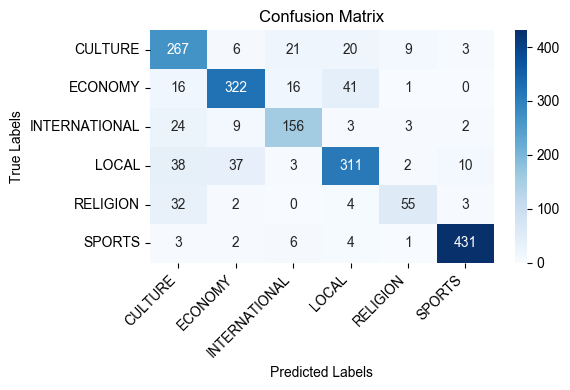

In [ ]:
print("\nModel Evaluation (On Test Set):")
y_pred, y_true = evaluate_model(model, test_loader, device)
acc = (np.array(y_pred) == np.array(y_true)).mean()
print(f"Accuracy: {acc:.4f}")

print("\nClassification Report:")
class_report = classification_report(y_true, y_pred, target_names=label_encoder.classes_)
print(class_report)

print("\nConfusion Matrix:")
show_confusion_matrix(decode_labels(y_true), decode_labels(y_pred), labels=sorted(set(decode_labels(y_true)) | set(decode_labels(y_pred))))

In [ ]:
def lstm_predict(text, model, vocab):
    pass